## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [99]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [100]:
df = pd.read_csv('ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [101]:
df.shape[0] # to get the number of rows

294478

c. The number of unique users in the dataset.

In [102]:
df.user_id.nunique() # to get the number of unique users

290584

d. The proportion of users converted.

In [103]:
df.query('converted == 1').user_id.unique().size / df.user_id.unique().size # number of unique users converted divided by the all unique users

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [104]:
df.query('(landing_page == "new_page" & group != "treatment") | (landing_page == "old_page" & group == "treatment")').count()['user_id']

3893

f. Do any of the rows have missing values?

In [105]:
(df.isnull().count()['user_id'] == df.shape[0]) # no null values

True

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [106]:
# Here we took only the rows that the landing_page and group columns match.
# Using a query that returns only the rows when landing page is the new page and group is treatment
# Or the landing page is old_page and the group is control.
df2 = df.query('(landing_page == "new_page" & group == "treatment") | (landing_page == "old_page" & group == "control")')

In [107]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [108]:
df2.user_id.nunique() # to get the number of unique users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [109]:
df2.user_id.duplicated().sum() # Find the duplicated rows based on user_id only

1

c. What is the row information for the repeat **user_id**? 

In [110]:
# Using loc method to located the duplicated row -also based on the user_id only
df2.loc[df2.duplicated(subset=('user_id'))] 

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [111]:
# Droping the duplicated row
df2.drop_duplicates(subset=('user_id'),inplace=True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [112]:
df2.shape # Check if the row is dropping correctly

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [113]:
# Number of users that converted divided by the number of all users
df2.query('converted == 1').shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [114]:
# Number of users that converted in the control group only divided by the number of all control group users
Old = df2.query('converted == 1 & group == "control"').shape[0] / df2.query('group == "control"').shape[0]
Old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [115]:
# Number of users that converted in the treatment group only divided by the number of all treatment group users
New = df2.query('converted == 1 & group == "treatment"').shape[0] / df2.query('group == "treatment"').shape[0]
New

0.11880806551510564

d. What is the probability that an individual received the new page?

In [116]:
# The number of users that have new page divided by all users
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

In [117]:
ab_diffs =  New - Old
ab_diffs

-0.0015782389853555567

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

We can see that the probability of users who decide to pay for the company's product in the **old page** are **higher** than the **newer one**.<br>
And the **old page** has probability of converting higher than the generaly converting rate in the dataset while the **new page** has probability of converting lower than the generaly converting rate in the dataset.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0: $p_{new}$ - $p_{old}$ <= 0<br>
H1: $p_{new}$ - $p_{old}$ > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [118]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [119]:
df2old = df2.query('group == "control"') # Group all control uesrs in one df
df2new = df2.query('group == "treatment"') # Group all treatment uesrs in one df

In [120]:
old_size = df2old.shape[0]
new_size = df2new.shape[0]
print(old_size)
print(new_size)

145274
145310


a. What is the **convert rate** for $p_{new}$ under the null? 

In [121]:
# probability of p_new which is the same as converted success rate regardless of page
p_new = df2.query('converted == 1').shape[0] / df2.shape[0] 
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [122]:
# probability of p_old which is the same as converted success rate regardless of page
p_old = df2.query('converted == 1').shape[0] / df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [123]:
new_size

145310

d. What is $n_{old}$?

In [124]:
old_size

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [125]:
# Simulate a chance of 1 appearing with rate of p_new doing it new_size times
new_page_converted = np.random.binomial(2 , p_new , new_size)
new_page_converted

array([0, 0, 0, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [126]:
# Simulate a chance of 1 appearing with rate of p_old doing it new_old times
old_page_converted = np.random.binomial(2 ,p_old , old_size)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [127]:
# Taking the difference  between new_page_converted mean and old_page converted mean
new_page_converted.mean() - old_page_converted.mean()

-0.0010637952655478677

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [128]:
# same as before but we I am doing it 10,000 times
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=new_size, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0, 1], size=old_size, p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

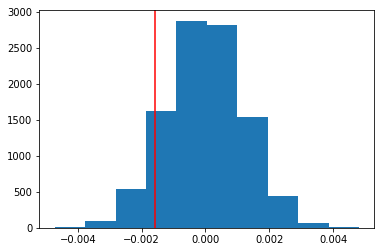

In [129]:
# Yes this is what I expect a normal distribution 
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.axvline(ab_diffs , color='r');

In [130]:
new_page_converted.mean() - old_page_converted.mean()

-0.0028378951717498435

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [131]:
# this is the P-Value for our statistic.
(p_diffs > ab_diffs).mean()

0.9046

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**ANSWER:** I just calculate the P-value of my statistical study, this value shows us if there is any statistical significants or not.
as we saw its 0.8188 and since our statistical significance is 0.05 we can say that my finding is statistically significant.<br>

with 0.82 p-value we fail to reject H0, meaning it better to keep the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [132]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 & group == "control"').shape[0] 
convert_new = df2.query('converted == 1 & group == "treatment"').shape[0]
n_old = old_size
n_new =  new_size

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

### link doesn't work anymore :( 

In [133]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:** Yes, both agree on the same thing. as we can see both have high p-value and that's mean statistical significance.<br>

and it's higher than 0.05 meaning that we fail to reject the null hypothesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Anwser:** since it has only two outcome, Logical regresstion is the way to go.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [134]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [135]:
# Creating dummy variables for the non-numeric values so we can use them in the regression
df2['intercept']=1
df2[['col2','ab_page']] = pd.get_dummies(df2['group'])
df2.drop(columns=('col2'),inplace = True)
df2

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [136]:
md = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res = md.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [137]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        06:01:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:** the p-value of ab_page is 0.19 which indicate a statistical significant still <br>
the p-value in part 2 is about 0.5 which is also higher than 0.05 meaning comparing them gives has the same result.<br>
the null hypothesis in logical regression is that there's no relationship between the dependent and independent variables and the alternative is there is a relationshit between them. since the p-value is high we fail to reject the h0 in this case.
<br>
the difference between part II and Part III is that part II is one tail test but the part III is two tail test regression test.



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** Gathering more data will definitely help us learn why our new_page is failing the test of bringing more traffic to our site. collecting things like the gender of the user and the age might help us to understand our visitor better, but it's hard since not all of the visitors are registered in our site. adding more X variables in the regression model will help us predict our y variable and get information about it if we want to manipulate one of the X variables.<br>
the disadvantages are that some problems might occur. like dependencies between the x variables will affect our result and might make it wrong. other problems like outliers that might hurt our model.<br>
so just to keep in mind all of these problems when are you adding more X variables to your model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [138]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [139]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [140]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [141]:
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])

In [142]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [143]:
md2 = sm.Logit(df_new['converted'],df_new[['intercept','CA','US']])
res2 = md2.fit()
res2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 May 2019   Pseudo R-squ.:               1.521e-05
Time:                        06:01:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

In [144]:
1/np.exp(-0.0507), 1/np.exp(-0.0099)

(1.052007243765014, 1.009949167117542)

**Answer:** as we can see, with the UK as our baseline we can say being from CA or US both have p-value over 0.05 meaning a significant result. so the conversion depends on what county you are in **but**, actually the difference is practically nothing since being from the US is 0.9% more likely to convert than the UK and being from CA is 5% more likely to convert it's almost no difference between the countries.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [145]:
### Fit Your Linear Model And Obtain the Results
df_new['US2'] = df_new['ab_page']*df_new['US'] 
df_new['UK2'] = df_new['ab_page']*df_new['UK']
df_new['CA2'] = df_new['ab_page']*df_new['CA']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,US2,UK2,CA2
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [146]:
md3 = sm.OLS(df_new['converted'],df_new[['intercept','ab_page','US','US2','UK','UK2']])
res3 = md3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Wed, 29 May 2019   Prob (F-statistic):              0.197
Time:                        06:01:07   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1188      0.004     31.057      0.000       0.111       0.126
ab_page       -0.0069      0.005     -1.277      0.202      -0.017       0.004
US             0.0018      0.004      0.467      0.641      -0.006       0.010
US2            0.0047      0.006      0.845      0.398      -0.006       0.016
UK             0.0012      0.004      0.296      0.767      -0.007       0.009
UK2            0.0080      0.006      1.360      0.174      -0.004       0.020
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Answer:** we can see that the R-squared is 0 meaning there's no effect in the prediction by this x variables


**Conclusion:** after making an A/B test for our new_page it turns out that the old_page is slightly better providing all the results that we get. so my discussion is to keep the old page.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.